In [3]:
# BiLSTM-based Intrusion Detection on TON IoT Dataset (Rewritten)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split

# Load Dataset
df = pd.read_csv('../dataset/final_df.csv', low_memory=False)
print("Original DataFrame Head:\n", df.head())
print("\nOriginal Class Distribution:\n", df['type'].value_counts())
print("\nOriginal Label Distribution:\n", df['label'].value_counts())
print("\nOriginal Data Types:\n", df.dtypes)
print("\nOriginal Data Shapes:\n", df.shape)

# --- Data Preprocessing ---
# Clean and impute
df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce').fillna(0)
df.drop_duplicates(inplace=True)

df.fillna(df.mean(numeric_only=True), inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True) # Or df[col].mode()[0]
        else:
            df[col].fillna(df[col].mean(), inplace=True)

print(f"Shape after handling NaNs: {df.shape}")

# Identify targets
TARGET_LABEL = 'label'
TARGET_TYPE = 'type'

# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if TARGET_TYPE in categorical_cols:
    categorical_cols.remove(TARGET_TYPE)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded column: {col}")

# Normalize numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if TARGET_LABEL in numerical_cols:
    numerical_cols.remove(TARGET_LABEL)

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


Original DataFrame Head:
            ts         src_ip  src_port        dst_ip  dst_port proto service  \
0  1556499101  192.168.1.193     60396  192.168.1.33      8080   tcp       -   
1  1556494424  192.168.1.193     59273  192.168.1.33      8080   tcp       -   
2  1556487945  192.168.1.193     57717  192.168.1.33      8080   tcp       -   
3  1556508616  192.168.1.193     62682  192.168.1.33        80   tcp       -   
4  1556511697  192.168.1.193     63419  192.168.1.33      8080   tcp       -   

   duration src_bytes  dst_bytes  ... http_response_body_len  \
0  0.000180         0          0  ...                      0   
1  0.000111         0          0  ...                      0   
2  0.000148         0          0  ...                      0   
3  0.000127         0          0  ...                      0   
4  0.000122         0          0  ...                      0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0                 0                -          

In [4]:
binary_y = df[TARGET_LABEL].values
type_encoder = LabelEncoder()
y_multiclass_encoded = type_encoder.fit_transform(df[TARGET_TYPE])
num_classes = len(le.classes_)
# Convert to one-hot encoding for Keras if using categorical_crossentropy
y_multiclass_onehot = to_categorical(y_multiclass_encoded)

y_multiclass_labels = np.argmax(y_multiclass_onehot, axis=1)

# Drop targets from features
X = df.drop(columns=[TARGET_LABEL, TARGET_TYPE]).values
print("Feature shape (flat):", X.shape)
print("Binary target shape:", binary_y.shape)
print("Multi-class target shape:", y_multiclass_labels.shape)

# print the class distribution of binary_y and y_multiclass_labels
print("Binary target class distribution:")
print(Counter(binary_y))
print("Multi-class target class distribution:")
print(Counter(y_multiclass_labels))

Feature shape (flat): (441043, 44)
Binary target shape: (441043,)
Multi-class target shape: (441043,)
Binary target class distribution:
Counter({np.int64(0): 300000, np.int64(1): 141043})
Multi-class target class distribution:
Counter({np.int64(5): 300000, np.int64(0): 20000, np.int64(1): 20000, np.int64(2): 20000, np.int64(3): 20000, np.int64(6): 20000, np.int64(7): 20000, np.int64(8): 20000, np.int64(4): 1043})


In [5]:
# 1. Split BEFORE SMOTE (to avoid leakage)
# ----------------------------------------
X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X,
    y_multiclass_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_multiclass_encoded  # stratify on binary for this example
)

# Reset indices
X_train = pd.DataFrame(X_train).reset_index(drop=True).values
X_test = pd.DataFrame(X_test).reset_index(drop=True).values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train_multiclass labels shape: {y_train_multi.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test_multiclass labels shape: {y_test_multi.shape}")

# print the class distribution of binary_y and y_multiclass
# print the class distribution of binary_y and y_multiclass
print("Multi-class target class distribution (train):")
print(Counter(np.argmax(y_train_multi, axis=1)))
print("Multi-class target class distribution (test):")
print(Counter(np.argmax(y_test_multi, axis=1)))

# scaling the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling complete.")


X_train shape: (352834, 44)
y_train_multiclass labels shape: (352834, 9)
X_test  shape: (88209, 44)
y_test_multiclass labels shape: (88209, 9)
Multi-class target class distribution (train):
Counter({np.int64(5): 240000, np.int64(0): 16000, np.int64(6): 16000, np.int64(7): 16000, np.int64(8): 16000, np.int64(2): 16000, np.int64(1): 16000, np.int64(3): 16000, np.int64(4): 834})
Multi-class target class distribution (test):
Counter({np.int64(5): 60000, np.int64(1): 4000, np.int64(3): 4000, np.int64(6): 4000, np.int64(0): 4000, np.int64(8): 4000, np.int64(7): 4000, np.int64(2): 4000, np.int64(4): 209})
Scaling complete.


In [6]:
# --- Create Sequences ---
def create_sequences(
    X,
    y,
    window_size: int = 10,
    debug: bool = False,
    trace_limit: int = 5
):
    # Convert to numpy if not already
    X = np.asarray(X)
    y = np.asarray(y)

    # Input validation
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if len(X.shape) != 2:
        raise ValueError("X must be a 2D array: (samples, features)")
    if len(y.shape) > 2:
        raise ValueError("y must be a 1D or 2D array")

    X_seq, y_seq = [], []
    total = len(X) - window_size + 1
    if debug:
        print(f"Total samples: {len(X)} | Generating {total} sequences (window_size={window_size})")

    for i in range(total):
        window = X[i : i + window_size]
        label = y[i + window_size - 1]
        X_seq.append(window)
        y_seq.append(label)

        if debug and i < trace_limit:
            print(f"\n--- Seq {i+1}/{total} ---")
            print(f"  X indices: {i} to {i+window_size-1}")
            print(f"  y index:   {i+window_size-1} → label={label}")
            print(f"  window.shape: {window.shape}")

    if debug:
        print(f"\nTotal sequences generated: {len(X_seq)}")

    return np.array(X_seq), np.array(y_seq)


TIMESTEPS = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train_multi, window_size=TIMESTEPS, debug=True)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_multi, window_size=TIMESTEPS, debug=True)


print("Train sequence shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("Test sequence shape:", X_test_seq.shape)
print("multi target distribution:", Counter(np.argmax(y_train_multi, axis=1)))

# counters
print("Class distribution in y_train_seq:", Counter(np.argmax(y_train_seq, axis=1)))
print("Class distribution in y_test_seq:", Counter(np.argmax(y_test_seq, axis=1)))

# multiclass sequence generation.
# X_train_seq_multi, y_train_seq_multi = create_sequences(X_train, y_train_multi, debug=True)
# X_test_seq_multi, y_test_seq_multi = create_sequences(X_test, y_test_multi, debug=True)


Total samples: 352834 | Generating 352815 sequences (window_size=20)

--- Seq 1/352815 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 1. 0. 0. 0. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/352815 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 3/352815 ---
  X indices: 2 to 21
  y index:   21 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 4/352815 ---
  X indices: 3 to 22
  y index:   22 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 5/352815 ---
  X indices: 4 to 23
  y index:   23 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

Total sequences generated: 352815
Total samples: 88209 | Generating 88190 sequences (window_size=20)

--- Seq 1/88190 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/88190 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.

In [7]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Convert one-hot to integer labels for y_train_seq
y_train_seq_labels = np.argmax(y_train_seq, axis=1)

# Apply ADASYN instead of SMOTE
adasyn = ADASYN(
    sampling_strategy={4: 10000},  # Only oversample class 4
    random_state=42,
    n_neighbors=5
)
X_train_res, y_train_res = adasyn.fit_resample(
	X_train_seq.reshape(X_train_seq.shape[0], -1),  # Flatten for ADASYN
	y_train_seq_labels
)
X_train_res = X_train_res.reshape(X_train_res.shape[0], TIMESTEPS, X_train_seq.shape[2])  # Reshape back to sequences
y_train_res = to_categorical(y_train_res, num_classes=y_train_seq.shape[1])  # One-hot encode	
print("After ADASYN:")
print("Resampled X_train shape:", X_train_res.shape)
print("Resampled y_train shape:", y_train_res.shape)
print("Resampled class distribution:", Counter(np.argmax(y_train_res, axis=1)))

After ADASYN:
Resampled X_train shape: (361902, 20, 44)
Resampled y_train shape: (361902, 9)
Resampled class distribution: Counter({np.int64(5): 239988, np.int64(2): 16000, np.int64(1): 16000, np.int64(3): 16000, np.int64(6): 15999, np.int64(8): 15999, np.int64(0): 15999, np.int64(7): 15997, np.int64(4): 9920})


In [8]:
from sklearn.utils import shuffle

X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_res, y_train_res, random_state=42)
# X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq, y_train_seq, random_state=42)

val_fraction = 0.2
n_total = X_train_seq_bal_shuffle.shape[0]
n_val = int(n_total * val_fraction)

X_val_seq = X_train_seq_bal_shuffle[-n_val:]
y_val_seq = y_train_seq_bal_shuffle[-n_val:]
X_train_seq_final = X_train_seq_bal_shuffle[:-n_val]
y_train_seq_final = y_train_seq_bal_shuffle[:-n_val]

print("Final training shapes:")
print(f"X_train_seq_final shape: {X_train_seq_final.shape}")
print(f"y_train_seq_final shape: {y_train_seq_final.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

print("Final training label distributions:")
print(f"y_train_seq_final distribution: {Counter(np.argmax(y_train_seq_final, axis=1))}")
print(f"y_val_seq distribution: {Counter(np.argmax(y_val_seq, axis=1))}")

Final training shapes:
X_train_seq_final shape: (289522, 20, 44)
y_train_seq_final shape: (289522, 9)
X_val_seq shape: (72380, 20, 44)
y_val_seq shape: (72380, 9)
Final training label distributions:
y_train_seq_final distribution: Counter({np.int64(5): 192140, np.int64(3): 12871, np.int64(7): 12853, np.int64(2): 12846, np.int64(8): 12748, np.int64(6): 12738, np.int64(1): 12701, np.int64(0): 12680, np.int64(4): 7945})
y_val_seq distribution: Counter({np.int64(5): 47848, np.int64(0): 3319, np.int64(1): 3299, np.int64(6): 3261, np.int64(8): 3251, np.int64(2): 3154, np.int64(7): 3144, np.int64(3): 3129, np.int64(4): 1975})


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# Model definition
model = Sequential([
    Bidirectional(LSTM(
        128, 
        return_sequences=True,  # Only final output
        recurrent_dropout=0.2,
        recurrent_activation='sigmoid',
        activation='tanh'
    ),
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    LayerNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])
model.summary()

optimizer = Adam(
    learning_rate=0.0001,  # Very low initial LR
    clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Recall(name='recall'),
        Precision(name='precision')
    ]
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,        # Key Change: Much lower patience
    mode='min',
    restore_best_weights=True, # This is correct and crucial
    verbose=1
)

# Reduce learning rate after 2 epochs of no improvement
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,        # Usually, LR reduction has a lower patience than early stopping
    min_lr=1e-6,
    verbose=1
)

frequencies = np.sum(y_train_seq_final, axis=0)
median_freq = np.median(frequencies)
class_weights = {cls: median_freq / count for cls, count in enumerate(frequencies)}

print("Class weights for training:", class_weights)

# Train
history = model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

results = model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


I0000 00:00:1757387844.946681  273319 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 256)        │       177,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 20, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,113 (1.34 MB)

 Trainable params: 351,113 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Class weights for training: {0: np.float64(1.0053627760252366), 1: np.float64(1.003700496023935), 2: np.float64(0.9923711661217499), 3: np.float64(0.9904436329733509), 4: np.float64(1.6045311516677156), 5: np.float64(0.06634745498074321), 6: np.float64(1.000785052598524), 7: np.float64(0.9918307010036568), 8: np.float64(1.0)}
Epoch 1/10


2025-09-09 09:02:38.483117: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


4524/4524 ━━━━━━━━━━━━━━━━━━━━ 176s 37ms/step - accuracy: 0.5804 - auc: 0.9097 - loss: 0.4492 - precision: 0.7710 - recall: 0.4617 - val_accuracy: 0.7554 - val_auc: 0.9599 - val_loss: 0.7750 - val_precision: 0.8238 - val_recall: 0.6713 - learning_rate: 1.0000e-04
Epoch 2/10
4524/4524 ━━━━━━━━━━━━━━━━━━━━ 168s 37ms/step - accuracy: 0.8125 - auc: 0.9767 - loss: 0.1949 - precision: 0.8484 - recall: 0.7802 - val_accuracy: 0.9020 - val_auc: 0.9874 - val_loss: 0.3732 - val_precision: 0.9123 - val_recall: 0.8956 - learning_rate: 1.0000e-04
Epoch 3/10
4524/4524 ━━━━━━━━━━━━━━━━━━━━ 169s 37ms/step - accuracy: 0.8781 - auc: 0.9870 - loss: 0.1176 - precision: 0.8923 - recall: 0.8655 - val_accuracy: 0.9186 - val_auc: 0.9909 - val_loss: 0.2947 - val_precision: 0.9264 - val_recall: 0.9117 - learning_rate: 1.0000e-04
Epoch 4/10
4524/4524 ━━━━━━━━━━━━━━━━━━━━ 169s 37ms/step - accuracy: 0.9025 - auc: 0.9900 - loss: 0.0873 - precision: 0.9118 - recall: 0.8935 - val_accuracy: 0.9276 - val_auc: 0.9913 - v

['backdoor' 'ddos' 'dos' 'injection' 'mitm' 'normal' 'password' 'scanning'
 'xss']
Encoded class 0 -> backdoor
Encoded class 1 -> ddos
Encoded class 2 -> dos
Encoded class 3 -> injection
Encoded class 4 -> mitm
Encoded class 5 -> normal
Encoded class 6 -> password
Encoded class 7 -> scanning
Encoded class 8 -> xss
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3997
           1       0.92      0.97      0.94      3998
           2       0.95      0.96      0.96      4000
           3       0.89      0.99      0.94      3999
           4       0.18      0.99      0.31       209
           5       1.00      0.96      0.98     59991
           6       0.89      1.00      0.94      3998
           7       0.94      0.99      0.97      3999
           8       0.95      0.93      0.94      3999

    accuracy                           0.96     88190
   macro avg       0.85      0.98      0.88

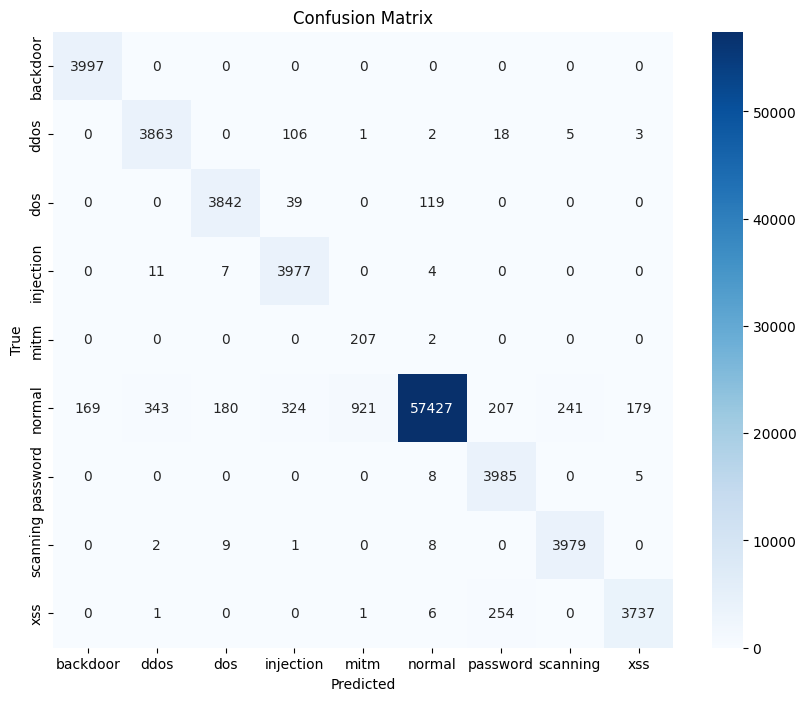

    Class      FNR      FPR
 backdoor 0.000000 0.002007
     ddos 0.033767 0.004240
      dos 0.039500 0.002328
injection 0.005501 0.005583
     mitm 0.009569 0.010491
   normal 0.042740 0.005284
 password 0.003252 0.005689
 scanning 0.005001 0.002922
      xss 0.065516 0.002221


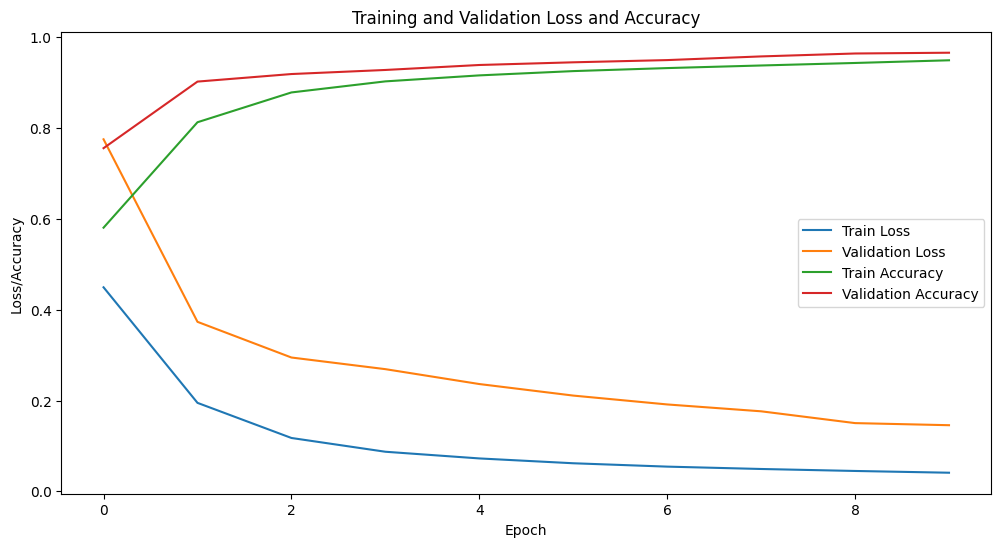

In [10]:
import seaborn as sns

# original class labels (what was in df[TARGET_TYPE])
print(type_encoder.classes_)

# numeric codes assigned
for i, cls in enumerate(type_encoder.classes_):
    print(f"Encoded class {i} -> {cls}")


# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq.argmax(axis=1)
print(classification_report(y_true_classes, y_pred_classes))

#confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=type_encoder.classes_,
            yticklabels=type_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# For multi-class, FNR and FPR are not simply tn, fp, fn, tp.
# If you want per-class FNR/FPR:
fnr = []
fpr = []
for i in range(cm.shape[0]):
    fn = cm[i, :].sum() - cm[i, i]
    tp = cm[i, i]
    fp = cm[:, i].sum() - cm[i, i]
    tn = cm.sum() - (tp + fn + fp)
    fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

results_df = pd.DataFrame({
    "Class": type_encoder.classes_,
    "FNR": fnr,
    "FPR": fpr
})

print(results_df.to_string(index=False))
# print("False Negative Rate (FNR) per class:", fnr)
# print("False Positive Rate (FPR) per class:", fpr)

# plot validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


In [11]:
# Hyperparameter Tuning with Bayesian Optimization (BayesSearchCV)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

def build_bilstm_model(
    lstm_units=64,
    hidden_layer=32,
    dropout=0.2,
    learning_rate=0.001,
    input_shape=(30, 44)
):
    model = Sequential([
        Bidirectional(LSTM(int(lstm_units*2), return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2), input_shape=input_shape),
        LayerNormalization(),
        Dropout(dropout),
        Bidirectional(LSTM(int(lstm_units))),
        LayerNormalization(),
        Dropout(dropout),
        Dense(int(hidden_layer), activation='relu'),
        Dense(9, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.metrics import make_scorer

def constrained_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = accuracy_score(y_true, y_pred)
        # Constraints: FNR ≤ 0.01, FPR ≤ 0.5, Accuracy > 0.90
        if fnr <= 0.01 and fpr <= 0.5 and acc > 0.90:
            print(f"Valid model found: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return acc
        else:
            print(f"Model rejected: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return 0
    else:
        # If confusion matrix is not 2x2, return 0
        return 0

constrained_scorer = make_scorer(constrained_score)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

# Wrap the model for scikit-learn compatibility
keras_clf = KerasClassifier(
    model=build_bilstm_model,
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2]),
    verbose=1
)

# Define the hyperparameter search space
param_space = {
    'model__lstm_units': Integer(64, 128),
    'model__hidden_layer': Integer(16, 32),
    'model__dropout': Real(0.2, 0.4),
    'model__learning_rate': Real(1e-4, 1e-2, prior='log-uniform'),
    'batch_size': Categorical([64, 128]),
    'epochs': Integer(5, 10)
}

opt = BayesSearchCV(
    estimator=keras_clf,
    search_spaces=param_space,
    n_iter=10,
    # scoring=constrained_scorer,
    scoring="accuracy",
    # cv=2,
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    refit=True
)

# Convert one-hot encoded targets to integer labels
y_train_seq_final_labels = np.argmax(y_train_seq_final, axis=1)
y_test_seq_labels = np.argmax(y_test_seq, axis=1)

# Fit the optimizer (this may take a while)
opt.fit(X_train_seq_final, y_train_seq_final_labels, callbacks=[early_stopping, reduce_lr], validation_split=0.2, class_weight=class_weight_dict, verbose=1)

print('Best parameters:', opt.best_params_)
print('Best cross-validation accuracy:', opt.best_score_)

# Evaluate on test set
test_score = opt.score(X_test_seq, y_test_seq_labels)
print('Test set accuracy:', test_score)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 94s 37ms/step - accuracy: 0.4816 - loss: 1.8688 - val_accuracy: 0.7189 - val_loss: 0.9378
Epoch 2/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 96s 40ms/step - accuracy: 0.7555 - loss: 0.9722 - val_accuracy: 0.8543 - val_loss: 0.5097
Epoch 3/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.8397 - loss: 0.6325 - val_accuracy: 0.9010 - val_loss: 0.3971
Epoch 4/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8638 - loss: 0.5044 - val_accuracy: 0.9040 - val_loss: 0.3824
Epoch 5/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.8788 - loss: 0.4181 - val_accuracy: 0.9199 - val_loss: 0.3281
Epoch 6/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8916 - loss: 0.3592 - val_accuracy: 0.9071 - val_loss: 0.3264
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.36968991136373597, model__hidden_layer=28, model__learning_rate=0.0004230359046414507, model__lstm_units=65; total tim

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 95s 38ms/step - accuracy: 0.4810 - loss: 1.8646 - val_accuracy: 0.7420 - val_loss: 0.8765
Epoch 2/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.7764 - loss: 0.9027 - val_accuracy: 0.8621 - val_loss: 0.5141
Epoch 3/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8509 - loss: 0.5616 - val_accuracy: 0.8923 - val_loss: 0.4161
Epoch 4/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8740 - loss: 0.4254 - val_accuracy: 0.9059 - val_loss: 0.3914
Epoch 5/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8862 - loss: 0.3665 - val_accuracy: 0.9139 - val_loss: 0.3377
Epoch 6/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8940 - loss: 0.3181 - val_accuracy: 0.9282 - val_loss: 0.2961
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.36968991136373597, model__hidden_layer=28, model__learning_rate=0.0004230359046414507, model__lstm_units=65; total tim

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 95s 38ms/step - accuracy: 0.4511 - loss: 1.9694 - val_accuracy: 0.7525 - val_loss: 0.8533
Epoch 2/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.7246 - loss: 1.1054 - val_accuracy: 0.8298 - val_loss: 0.6598
Epoch 3/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8077 - loss: 0.7189 - val_accuracy: 0.8487 - val_loss: 0.5113
Epoch 4/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8519 - loss: 0.5317 - val_accuracy: 0.9039 - val_loss: 0.3792
Epoch 5/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8744 - loss: 0.4167 - val_accuracy: 0.8883 - val_loss: 0.4060
Epoch 6/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8862 - loss: 0.3508 - val_accuracy: 0.9242 - val_loss: 0.3038
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.36968991136373597, model__hidden_layer=28, model__learning_rate=0.0004230359046414507, model__lstm_units=65; total tim

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - accuracy: 0.2095 - loss: 2.2631 - val_accuracy: 0.2556 - val_loss: 1.5172
Epoch 2/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5137 - loss: 1.6502 - val_accuracy: 0.6990 - val_loss: 0.9687
Epoch 3/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.6350 - loss: 1.6345 - val_accuracy: 0.6460 - val_loss: 1.2739
Epoch 4/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.6648 - loss: 1.7346 - val_accuracy: 0.7575 - val_loss: 0.8710
Epoch 5/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.6737 - loss: 1.7670 - val_accuracy: 0.7840 - val_loss: 0.7995
Epoch 6/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.6785 - loss: 1.6862 - val_accuracy: 0.7035 - val_loss: 0.9852
Epoch 7/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.6822 - loss: 1.7286 - val_accuracy: 0.7476 - val_loss: 0.9988
754/754 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
[CV] END batch_size=128, epochs=7, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 60s 45ms/step - accuracy: 0.2787 - loss: 2.0675 - val_accuracy: 0.5042 - val_loss: 1.1809
Epoch 2/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5219 - loss: 1.5495 - val_accuracy: 0.5401 - val_loss: 1.2365
Epoch 3/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.6525 - loss: 1.5215 - val_accuracy: 0.7837 - val_loss: 0.7684
Epoch 4/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.6813 - loss: 1.6767 - val_accuracy: 0.7339 - val_loss: 0.9429
Epoch 5/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.6870 - loss: 1.8232 - val_accuracy: 0.7692 - val_loss: 0.9595
Epoch 6/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.7035 - loss: 1.7357 - val_accuracy: 0.7162 - val_loss: 1.1066
Epoch 7/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.6820 - loss: 1.7608 - val_accuracy: 0.7393 - val_loss: 1.0473
754/754 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
[CV] END batch_size=128, epochs=7, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - accuracy: 0.3713 - loss: 1.9510 - val_accuracy: 0.5763 - val_loss: 1.3357
Epoch 2/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.6251 - loss: 1.5104 - val_accuracy: 0.6565 - val_loss: 1.1074
Epoch 3/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.6829 - loss: 1.4487 - val_accuracy: 0.7960 - val_loss: 0.7690
Epoch 4/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.7108 - loss: 1.4464 - val_accuracy: 0.8145 - val_loss: 0.6699
Epoch 5/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.7233 - loss: 1.5444 - val_accuracy: 0.7880 - val_loss: 0.9118
Epoch 6/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.7315 - loss: 1.6240 - val_accuracy: 0.7941 - val_loss: 0.7982
Epoch 7/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.7365 - loss: 1.6565 - val_accuracy: 0.7918 - val_loss: 0.8192
754/754 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
[CV] END batch_size=128, epochs=7, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 55s 42ms/step - accuracy: 0.4446 - loss: 1.7643 - val_accuracy: 0.6791 - val_loss: 0.9876
Epoch 2/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.6663 - loss: 1.2987 - val_accuracy: 0.7954 - val_loss: 0.7413
Epoch 3/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - accuracy: 0.7349 - loss: 1.0894 - val_accuracy: 0.8241 - val_loss: 0.6569
Epoch 4/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - accuracy: 0.7580 - loss: 0.9923 - val_accuracy: 0.8462 - val_loss: 0.6021
Epoch 5/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.7950 - loss: 0.8415 - val_accuracy: 0.8251 - val_loss: 0.6583
Epoch 6/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - accuracy: 0.8203 - loss: 0.7615 - val_accuracy: 0.8938 - val_loss: 0.4473
Epoch 7/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - accuracy: 0.8338 - loss: 0.7008 - val_accuracy: 0.8958 - val_loss: 0.4265
Epoch 8/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - accuracy: 0.8419 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.3917 - loss: 1.8250 - val_accuracy: 0.6553 - val_loss: 1.0420
Epoch 2/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.7078 - loss: 1.2166 - val_accuracy: 0.8276 - val_loss: 0.5936
Epoch 3/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.7799 - loss: 0.9065 - val_accuracy: 0.8224 - val_loss: 0.6098
Epoch 4/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.8198 - loss: 0.7051 - val_accuracy: 0.8793 - val_loss: 0.4458
Epoch 5/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.8369 - loss: 0.6297 - val_accuracy: 0.8795 - val_loss: 0.4875
Epoch 6/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.8548 - loss: 0.5724 - val_accuracy: 0.8958 - val_loss: 0.4180
Epoch 7/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.8619 - loss: 0.5239 - val_accuracy: 0.9027 - val_loss: 0.4200
Epoch 8/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.8614 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - accuracy: 0.5427 - loss: 1.5540 - val_accuracy: 0.7554 - val_loss: 0.8804
Epoch 2/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.7069 - loss: 1.2146 - val_accuracy: 0.7877 - val_loss: 0.7514
Epoch 3/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.7570 - loss: 1.0355 - val_accuracy: 0.7914 - val_loss: 0.7310
Epoch 4/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.7939 - loss: 0.8560 - val_accuracy: 0.8473 - val_loss: 0.4796
Epoch 5/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.8174 - loss: 0.7649 - val_accuracy: 0.8614 - val_loss: 0.4673
Epoch 6/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.8421 - loss: 0.6393 - val_accuracy: 0.8712 - val_loss: 0.4418
Epoch 7/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.8510 - loss: 0.6080 - val_accuracy: 0.9066 - val_loss: 0.3779
Epoch 8/8
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.8617 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 63s 49ms/step - accuracy: 0.5437 - loss: 1.6361 - val_accuracy: 0.7752 - val_loss: 0.7565
Epoch 2/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.7676 - loss: 0.9434 - val_accuracy: 0.8587 - val_loss: 0.4905
Epoch 3/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8368 - loss: 0.5780 - val_accuracy: 0.8884 - val_loss: 0.4923
Epoch 4/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8563 - loss: 0.4839 - val_accuracy: 0.8590 - val_loss: 0.4958
Epoch 5/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8644 - loss: 0.4584 - val_accuracy: 0.9131 - val_loss: 0.3575
754/754 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
[CV] END batch_size=128, epochs=5, model__dropout=0.35432876500968735, model__hidden_layer=19, model__learning_rate=0.0017912116195168797, model__lstm_units=109; total time= 5.1min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - accuracy: 0.5805 - loss: 1.5801 - val_accuracy: 0.7667 - val_loss: 0.8239
Epoch 2/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.7725 - loss: 0.9297 - val_accuracy: 0.8561 - val_loss: 0.5425
Epoch 3/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8428 - loss: 0.5716 - val_accuracy: 0.8947 - val_loss: 0.4415
Epoch 4/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8604 - loss: 0.4681 - val_accuracy: 0.8951 - val_loss: 0.3939
Epoch 5/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8636 - loss: 0.4610 - val_accuracy: 0.9118 - val_loss: 0.3527
754/754 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
[CV] END batch_size=128, epochs=5, model__dropout=0.35432876500968735, model__hidden_layer=19, model__learning_rate=0.0017912116195168797, model__lstm_units=109; total time= 5.1min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - accuracy: 0.5362 - loss: 1.6613 - val_accuracy: 0.7903 - val_loss: 0.7338
Epoch 2/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.7400 - loss: 1.1061 - val_accuracy: 0.8205 - val_loss: 0.6205
Epoch 3/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8178 - loss: 0.7169 - val_accuracy: 0.8809 - val_loss: 0.4181
Epoch 4/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8429 - loss: 0.5548 - val_accuracy: 0.8871 - val_loss: 0.4340
Epoch 5/5
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8562 - loss: 0.4831 - val_accuracy: 0.9170 - val_loss: 0.3255
754/754 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
[CV] END batch_size=128, epochs=5, model__dropout=0.35432876500968735, model__hidden_layer=19, model__learning_rate=0.0017912116195168797, model__lstm_units=109; total time= 5.1min
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 94s 37ms/step - accuracy: 0.4546 - loss: 1.9035 - val_accuracy: 0.6734 - val_loss: 0.9804
Epoch 2/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.7527 - loss: 1.0032 - val_accuracy: 0.8599 - val_loss: 0.4947
Epoch 3/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8425 - loss: 0.5908 - val_accuracy: 0.8980 - val_loss: 0.3832
Epoch 4/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8797 - loss: 0.4107 - val_accuracy: 0.9139 - val_loss: 0.3515
Epoch 5/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8955 - loss: 0.3274 - val_accuracy: 0.9247 - val_loss: 0.3049
Epoch 6/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.9051 - loss: 0.2592 - val_accuracy: 0.9324 - val_loss: 0.2689
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.21349217543002436, model__hidden_layer=30, model__learning_rate=0.00021409728728692218, model__lstm_units=66; total ti

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 93s 37ms/step - accuracy: 0.4091 - loss: 1.9906 - val_accuracy: 0.7229 - val_loss: 0.8724
Epoch 2/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.7301 - loss: 1.0342 - val_accuracy: 0.8436 - val_loss: 0.5994
Epoch 3/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8322 - loss: 0.5806 - val_accuracy: 0.8972 - val_loss: 0.4221
Epoch 4/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8772 - loss: 0.3955 - val_accuracy: 0.9118 - val_loss: 0.3576
Epoch 5/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8951 - loss: 0.3202 - val_accuracy: 0.9262 - val_loss: 0.3059
Epoch 6/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.9060 - loss: 0.2737 - val_accuracy: 0.9151 - val_loss: 0.3035
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.21349217543002436, model__hidden_layer=30, model__learning_rate=0.00021409728728692218, model__lstm_units=66; total ti

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 93s 37ms/step - accuracy: 0.4453 - loss: 1.8474 - val_accuracy: 0.6930 - val_loss: 0.9097
Epoch 2/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.7455 - loss: 1.0003 - val_accuracy: 0.8695 - val_loss: 0.4959
Epoch 3/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8471 - loss: 0.5800 - val_accuracy: 0.9134 - val_loss: 0.3395
Epoch 4/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8809 - loss: 0.3932 - val_accuracy: 0.9111 - val_loss: 0.3313
Epoch 5/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8978 - loss: 0.3090 - val_accuracy: 0.9300 - val_loss: 0.2799
Epoch 6/6
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.9100 - loss: 0.2613 - val_accuracy: 0.9362 - val_loss: 0.2405
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.21349217543002436, model__hidden_layer=30, model__learning_rate=0.00021409728728692218, model__lstm_units=66; total ti

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - accuracy: 0.4389 - loss: 1.8245 - val_accuracy: 0.7060 - val_loss: 0.8713
Epoch 2/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.6908 - loss: 1.2593 - val_accuracy: 0.8063 - val_loss: 0.7311
Epoch 3/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.7654 - loss: 1.0177 - val_accuracy: 0.8519 - val_loss: 0.6001
Epoch 4/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.7910 - loss: 0.8645 - val_accuracy: 0.8225 - val_loss: 0.5895
Epoch 5/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8280 - loss: 0.6875 - val_accuracy: 0.8847 - val_loss: 0.4010
Epoch 6/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8613 - loss: 0.5684 - val_accuracy: 0.9015 - val_loss: 0.3930
Epoch 7/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8690 - loss: 0.5107 - val_accuracy: 0.8990 - val_loss: 0.3849
754/754 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step
[CV] END batch_size=128, epochs=7, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 63s 49ms/step - accuracy: 0.5895 - loss: 1.5087 - val_accuracy: 0.7949 - val_loss: 0.7238
Epoch 2/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.7536 - loss: 1.0668 - val_accuracy: 0.7719 - val_loss: 0.6801
Epoch 3/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8185 - loss: 0.7057 - val_accuracy: 0.8908 - val_loss: 0.4021
Epoch 4/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8412 - loss: 0.5744 - val_accuracy: 0.8691 - val_loss: 0.4415
Epoch 5/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8591 - loss: 0.5170 - val_accuracy: 0.8452 - val_loss: 0.4988
Epoch 6/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8684 - loss: 0.4944 - val_accuracy: 0.8943 - val_loss: 0.3649
Epoch 7/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.8769 - loss: 0.4536 - val_accuracy: 0.8561 - val_loss: 0.3669
754/754 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
[CV] END batch_size=128, epochs=7, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - accuracy: 0.5444 - loss: 1.6639 - val_accuracy: 0.6103 - val_loss: 1.2822
Epoch 2/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.7097 - loss: 1.2681 - val_accuracy: 0.7878 - val_loss: 0.6714
Epoch 3/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accuracy: 0.7654 - loss: 0.9985 - val_accuracy: 0.8425 - val_loss: 0.5066
Epoch 4/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accuracy: 0.8261 - loss: 0.7649 - val_accuracy: 0.8983 - val_loss: 0.4638
Epoch 5/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accuracy: 0.8468 - loss: 0.6553 - val_accuracy: 0.8678 - val_loss: 0.5307
Epoch 6/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accuracy: 0.8639 - loss: 0.5556 - val_accuracy: 0.9078 - val_loss: 0.4187
Epoch 7/7
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accuracy: 0.8784 - loss: 0.4869 - val_accuracy: 0.9059 - val_loss: 0.3853
754/754 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
[CV] END batch_size=128, epochs=7, model

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 93s 37ms/step - accuracy: 0.5700 - loss: 1.6639 - val_accuracy: 0.7567 - val_loss: 0.8266
Epoch 2/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.7835 - loss: 0.9092 - val_accuracy: 0.8770 - val_loss: 0.5017
Epoch 3/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8460 - loss: 0.5623 - val_accuracy: 0.9071 - val_loss: 0.3921
Epoch 4/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8668 - loss: 0.4902 - val_accuracy: 0.9185 - val_loss: 0.3256
Epoch 5/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8728 - loss: 0.5079 - val_accuracy: 0.9091 - val_loss: 0.3527
Epoch 6/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8765 - loss: 0.4988 - val_accuracy: 0.8908 - val_loss: 0.4205
Epoch 7/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8800 - loss: 0.4870 - val_accuracy: 0.8988 - val_loss: 0.3959
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
[CV] END batch_size=64, epochs=7, mode

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 94s 37ms/step - accuracy: 0.5801 - loss: 1.6389 - val_accuracy: 0.8145 - val_loss: 0.7191
Epoch 2/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.7935 - loss: 0.9247 - val_accuracy: 0.8684 - val_loss: 0.5359
Epoch 3/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8516 - loss: 0.6066 - val_accuracy: 0.9173 - val_loss: 0.3660
Epoch 4/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8688 - loss: 0.4978 - val_accuracy: 0.9120 - val_loss: 0.3520
Epoch 5/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8795 - loss: 0.4599 - val_accuracy: 0.9194 - val_loss: 0.3005
Epoch 6/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8826 - loss: 0.4495 - val_accuracy: 0.9183 - val_loss: 0.3418
Epoch 7/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.8853 - loss: 0.4626 - val_accuracy: 0.9108 - val_loss: 0.3414
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
[CV] END batch_size=64, epochs=7, mode

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 96s 38ms/step - accuracy: 0.5898 - loss: 1.5249 - val_accuracy: 0.7899 - val_loss: 0.6678
Epoch 2/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8161 - loss: 0.7432 - val_accuracy: 0.9037 - val_loss: 0.3719
Epoch 3/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8477 - loss: 0.5973 - val_accuracy: 0.9015 - val_loss: 0.4054
Epoch 4/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8664 - loss: 0.5024 - val_accuracy: 0.8822 - val_loss: 0.3798
Epoch 5/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8769 - loss: 0.4753 - val_accuracy: 0.9235 - val_loss: 0.2717
Epoch 6/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8799 - loss: 0.4778 - val_accuracy: 0.9203 - val_loss: 0.2942
Epoch 7/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.8846 - loss: 0.4658 - val_accuracy: 0.8988 - val_loss: 0.3617
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
[CV] END batch_size=64, epochs=7, mode

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 114s 45ms/step - accuracy: 0.5455 - loss: 1.6624 - val_accuracy: 0.7945 - val_loss: 0.7053
Epoch 2/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.8227 - loss: 0.7578 - val_accuracy: 0.8848 - val_loss: 0.3936
Epoch 3/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.8774 - loss: 0.4333 - val_accuracy: 0.9056 - val_loss: 0.3445
Epoch 4/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.8940 - loss: 0.3234 - val_accuracy: 0.9257 - val_loss: 0.2788
Epoch 5/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.9086 - loss: 0.2582 - val_accuracy: 0.9294 - val_loss: 0.2435
Epoch 6/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.9198 - loss: 0.2069 - val_accuracy: 0.9420 - val_loss: 0.2170
Epoch 7/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.9294 - loss: 0.1840 - val_accuracy: 0.9495 - val_loss: 0.1993
Epoch 8/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.9345 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 113s 45ms/step - accuracy: 0.5660 - loss: 1.6367 - val_accuracy: 0.8206 - val_loss: 0.6895
Epoch 2/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.8115 - loss: 0.8421 - val_accuracy: 0.8928 - val_loss: 0.4078
Epoch 3/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.8699 - loss: 0.5007 - val_accuracy: 0.8968 - val_loss: 0.3363
Epoch 4/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.8928 - loss: 0.3580 - val_accuracy: 0.9249 - val_loss: 0.3204
Epoch 5/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.9073 - loss: 0.2863 - val_accuracy: 0.9246 - val_loss: 0.2738
Epoch 6/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.9133 - loss: 0.2559 - val_accuracy: 0.9287 - val_loss: 0.2388
Epoch 7/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.9193 - loss: 0.2237 - val_accuracy: 0.9332 - val_loss: 0.2364
Epoch 8/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.9287 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 112s 45ms/step - accuracy: 0.5287 - loss: 1.7196 - val_accuracy: 0.7716 - val_loss: 0.7307
Epoch 2/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.7980 - loss: 0.8202 - val_accuracy: 0.8833 - val_loss: 0.4296
Epoch 3/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.8690 - loss: 0.4971 - val_accuracy: 0.9122 - val_loss: 0.3697
Epoch 4/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.8946 - loss: 0.3492 - val_accuracy: 0.9233 - val_loss: 0.2939
Epoch 5/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.9087 - loss: 0.2869 - val_accuracy: 0.9208 - val_loss: 0.2761
Epoch 6/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.9209 - loss: 0.2392 - val_accuracy: 0.9472 - val_loss: 0.1885
Epoch 7/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.9305 - loss: 0.2179 - val_accuracy: 0.9394 - val_loss: 0.2444
Epoch 8/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.9353 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 103s 41ms/step - accuracy: 0.5803 - loss: 1.6354 - val_accuracy: 0.7829 - val_loss: 0.7921
Epoch 2/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.7937 - loss: 0.9218 - val_accuracy: 0.8754 - val_loss: 0.5057
Epoch 3/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.8409 - loss: 0.6436 - val_accuracy: 0.8926 - val_loss: 0.4481
Epoch 4/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.8601 - loss: 0.5659 - val_accuracy: 0.9070 - val_loss: 0.3665
Epoch 5/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.8728 - loss: 0.5424 - val_accuracy: 0.9213 - val_loss: 0.3387
Epoch 6/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.8781 - loss: 0.5411 - val_accuracy: 0.9070 - val_loss: 0.3820
Epoch 7/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.8880 - loss: 0.4925 - val_accuracy: 0.8988 - val_loss: 0.4135
Epoch 8/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.8884 - loss: 

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 104s 42ms/step - accuracy: 0.6102 - loss: 1.5995 - val_accuracy: 0.7886 - val_loss: 0.7950
Epoch 2/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.7967 - loss: 0.9254 - val_accuracy: 0.8808 - val_loss: 0.4160
Epoch 3/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.8493 - loss: 0.6133 - val_accuracy: 0.9042 - val_loss: 0.3153
Epoch 4/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8606 - loss: 0.5820 - val_accuracy: 0.8777 - val_loss: 0.3792
Epoch 5/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8746 - loss: 0.5575 - val_accuracy: 0.8887 - val_loss: 0.3933
Epoch 6/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8743 - loss: 0.5646 - val_accuracy: 0.9237 - val_loss: 0.3885
Epoch 7/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8820 - loss: 0.5714 - val_accuracy: 0.8952 - val_loss: 0.4116
Epoch 8/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8887 - l

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 104s 42ms/step - accuracy: 0.6023 - loss: 1.6266 - val_accuracy: 0.7903 - val_loss: 0.7289
Epoch 2/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.7935 - loss: 0.9398 - val_accuracy: 0.8848 - val_loss: 0.4357
Epoch 3/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8407 - loss: 0.6643 - val_accuracy: 0.8869 - val_loss: 0.4282
Epoch 4/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8584 - loss: 0.6177 - val_accuracy: 0.9077 - val_loss: 0.3406
Epoch 5/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8678 - loss: 0.5794 - val_accuracy: 0.8948 - val_loss: 0.3369
Epoch 6/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8758 - loss: 0.5904 - val_accuracy: 0.9154 - val_loss: 0.3218
Epoch 7/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8743 - loss: 0.5801 - val_accuracy: 0.9223 - val_loss: 0.3417
Epoch 8/9
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.8827 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 114s 46ms/step - accuracy: 0.3042 - loss: 2.1260 - val_accuracy: 0.5545 - val_loss: 1.1587
Epoch 2/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.6221 - loss: 1.7860 - val_accuracy: 0.7088 - val_loss: 0.9134
Epoch 3/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.6891 - loss: 1.9326 - val_accuracy: 0.7839 - val_loss: 0.8797
Epoch 4/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 110s 45ms/step - accuracy: 0.7150 - loss: 2.0497 - val_accuracy: 0.7878 - val_loss: 0.7863
Epoch 5/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 110s 46ms/step - accuracy: 0.7150 - loss: 2.1368 - val_accuracy: 0.7915 - val_loss: 0.7514
Epoch 6/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 110s 46ms/step - accuracy: 0.7231 - loss: 2.0773 - val_accuracy: 0.8047 - val_loss: 0.9047
Epoch 7/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 110s 45ms/step - accuracy: 0.7261 - loss: 2.1926 - val_accuracy: 0.8195 - val_loss: 0.7536
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step
[CV] END batch_size=64, epochs=

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 115s 46ms/step - accuracy: 0.3475 - loss: 2.2165 - val_accuracy: 0.6399 - val_loss: 0.9683
Epoch 2/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.6246 - loss: 1.8339 - val_accuracy: 0.7164 - val_loss: 0.8767
Epoch 3/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 110s 45ms/step - accuracy: 0.7018 - loss: 1.7680 - val_accuracy: 0.7468 - val_loss: 0.8652
Epoch 4/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.7122 - loss: 1.9292 - val_accuracy: 0.7567 - val_loss: 0.9090
Epoch 5/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.7174 - loss: 1.9085 - val_accuracy: 0.8128 - val_loss: 0.7053
Epoch 6/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.7482 - loss: 1.9164 - val_accuracy: 0.8601 - val_loss: 0.5910
Epoch 7/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.7482 - loss: 1.9962 - val_accuracy: 0.8765 - val_loss: 0.6869
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step
[CV] END batch_size=64, epochs=

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 115s 46ms/step - accuracy: 0.0274 - loss: 3.3019 - val_accuracy: 0.0286 - val_loss: 2.9684
Epoch 2/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.0272 - loss: 3.2485 - val_accuracy: 0.0286 - val_loss: 2.8308
Epoch 3/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.0272 - loss: 3.2467 - val_accuracy: 0.0286 - val_loss: 2.8422
Epoch 4/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.0272 - loss: 3.2463 - val_accuracy: 0.0286 - val_loss: 2.9229
Epoch 5/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.0272 - loss: 3.2460 - val_accuracy: 0.0286 - val_loss: 2.9274
Epoch 6/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.0272 - loss: 3.2462 - val_accuracy: 0.0286 - val_loss: 2.8609
Epoch 7/7
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step - accuracy: 0.0272 - loss: 3.2468 - val_accuracy: 0.0286 - val_loss: 2.8780
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step
[CV] END batch_size=64, epochs=

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 173s 46ms/step - accuracy: 0.6203 - loss: 1.4017 - val_accuracy: 0.8436 - val_loss: 0.5701
Epoch 2/9
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 166s 46ms/step - accuracy: 0.8633 - loss: 0.5425 - val_accuracy: 0.9082 - val_loss: 0.3324
Epoch 3/9
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 166s 46ms/step - accuracy: 0.8968 - loss: 0.3177 - val_accuracy: 0.9184 - val_loss: 0.2936
Epoch 4/9
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 166s 46ms/step - accuracy: 0.9184 - loss: 0.2418 - val_accuracy: 0.9434 - val_loss: 0.2209
Epoch 5/9
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 197s 55ms/step - accuracy: 0.9322 - loss: 0.1922 - val_accuracy: 0.9573 - val_loss: 0.1833
Epoch 6/9
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 192s 53ms/step - accuracy: 0.9399 - loss: 0.1753 - val_accuracy: 0.9612 - val_loss: 0.1756
Epoch 7/9
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 166s 46ms/step - accuracy: 0.9439 - loss: 0.1591 - val_accuracy: 0.9630 - val_loss: 0.1694
Epoch 8/9
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 166s 46ms/step - accuracy: 0.9474 -

In [ ]:
# use the best params obtained from the above bayes search to train the model again and evaluate on test set.
# Extract best parameters
best_params = opt.best_params_
# Build model with best parameters
model = build_bilstm_model(
    lstm_units=best_params['model__lstm_units'],
    hidden_layer=best_params['model__hidden_layer'],
    dropout=best_params['model__dropout'],
    learning_rate=best_params['model__learning_rate'],
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])
)

# Train the model
history = model.fit(
    X_train_seq_final, y_train_seq_final_labels,
    validation_data=(X_val_seq, np.argmax(y_val_seq, axis=1)),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate on test set
results = model.evaluate(X_test_seq, y_test_seq_labels, verbose=2)
print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3997
           1       0.90      0.96      0.93      3998
           2       0.82      0.97      0.89      4000
           3       0.91      0.96      0.93      3999
           4       0.18      0.83      0.29       209
           5       1.00      0.95      0.97     59991
           6       0.94      0.99      0.96      3998
           7       0.95      1.00      0.97      3999
           8       0.89      0.97      0.93      3999

    accuracy                           0.96     88190
   macro avg       0.84      0.96      0.87     88190
weighted avg       0.97      0.96      0.96     88190

[[ 3997     0     0     0     0     0     0     0     0]
 [    0  3844    11   134     0     4     2     2     1]
 [    0     2  3872     1     0   124     0     0     1]
 [    0    62    84  3825     0     2     0     1    25]
 [    0     0     2   

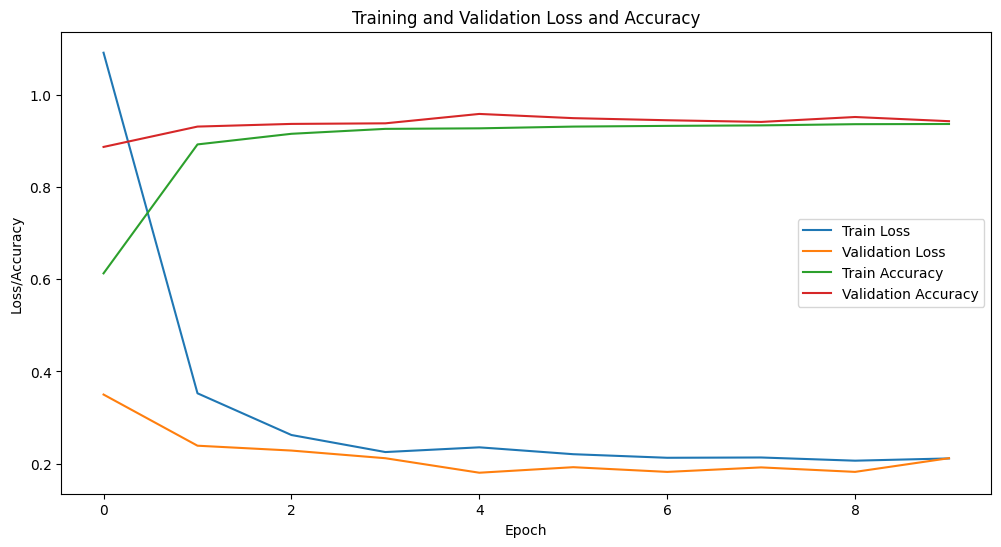

In [ ]:

# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq_labels
print(classification_report(y_true_classes, y_pred_classes))

# confusion matrics
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

#plot the validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')   
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()



In [ ]:
# Calculate FPR and FNR
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq_labels
cm = confusion_matrix(y_true_classes, y_pred_classes)

# For multi-class, calculate FNR and FPR per class
fnr = []
fpr = []
for i in range(cm.shape[0]):
	fn = cm[i, :].sum() - cm[i, i]
	tp = cm[i, i]
	fp = cm[:, i].sum() - cm[i, i]
	tn = cm.sum() - (tp + fn + fp)
	fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
	fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

print("False Negative Rate (FNR) per class:", fnr)
print("False Positive Rate (FPR) per class:", fpr)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step
False Negative Rate (FNR) per class: [np.float64(0.0), np.float64(0.03851925962981491), np.float64(0.032), np.float64(0.04351087771942986), np.float64(0.1722488038277512), np.float64(0.05025753863079462), np.float64(0.01025512756378189), np.float64(0.004001000250062516), np.float64(0.025506376594148537)]
False Positive Rate (FPR) per class: [np.float64(0.001057095007898519), np.float64(0.0052974154313949065), np.float64(0.009989309894286733), np.float64(0.004608568611846872), np.float64(0.00916106886714177), np.float64(0.005071101812120997), np.float64(0.0031238122386925125), np.float64(0.002672494684705016), np.float64(0.005523155681723699)]


In [ ]:
import pandas as pd

# Use type_encoder.classes_ to match the order and number of classes
results_df = pd.DataFrame({
    "Class": type_encoder.classes_,
    "FNR": fnr,
    "FPR": fpr
})

print(results_df.to_string(index=False))


    Class      FNR      FPR
 backdoor 0.000000 0.001057
     ddos 0.038519 0.005297
      dos 0.032000 0.009989
injection 0.043511 0.004609
     mitm 0.172249 0.009161
   normal 0.050258 0.005071
 password 0.010255 0.003124
 scanning 0.004001 0.002672
      xss 0.025506 0.005523
